# Analysis
Collect, aggregate and evaluate causal links. Produces causal (correlation) matrix plots.

# Main program

## Specifications

In [4]:
import sys, yaml, numpy as np
from os.path import exists

from utils.setup import SetupPCMCIAggregation
import utils.pcmci_aggregation as aggregation

argv = ['-c', './nn_config/cfg_aggregate_results.yml']
# argv = ['-c', './nn_config/cfg_aggregate_results_pearsonr.yml']

setup = SetupPCMCIAggregation(argv)


## Options

In [5]:
threshold_dict = False
num_parents    = True
insets         = False
masking        = False
save           = False

## Collect results

In [6]:
# collected_results, errors = aggregation.collect_results(setup)
collected_results, errors = aggregation.collect_results(setup, reuse=True)
print(aggregation.print_errors(errors))

Variable: tphystnd
SPCAM_Rasp_causal_links_3mth_v2/aggregate_pdf/tphystnd-3.64_parcorr_2021_09_02_TRAIN_For_Nando exists; loading...

SPCAM_Rasp_causal_links_3mth_v2/aggregate_pdf/tphystnd-7.59_parcorr_2021_09_02_TRAIN_For_Nando exists; loading...

SPCAM_Rasp_causal_links_3mth_v2/aggregate_pdf/tphystnd-14.36_parcorr_2021_09_02_TRAIN_For_Nando exists; loading...

SPCAM_Rasp_causal_links_3mth_v2/aggregate_pdf/tphystnd-24.61_parcorr_2021_09_02_TRAIN_For_Nando exists; loading...

SPCAM_Rasp_causal_links_3mth_v2/aggregate_pdf/tphystnd-38.27_parcorr_2021_09_02_TRAIN_For_Nando exists; loading...

SPCAM_Rasp_causal_links_3mth_v2/aggregate_pdf/tphystnd-54.6_parcorr_2021_09_02_TRAIN_For_Nando exists; loading...

SPCAM_Rasp_causal_links_3mth_v2/aggregate_pdf/tphystnd-72.01_parcorr_2021_09_02_TRAIN_For_Nando exists; loading...

SPCAM_Rasp_causal_links_3mth_v2/aggregate_pdf/tphystnd-87.82_parcorr_2021_09_02_TRAIN_For_Nando exists; loading...

SPCAM_Rasp_causal_links_3mth_v2/aggregate_pdf/tphystnd-1

## Analyze collected results

In [7]:
setup.thrs_argv = ['-c', './nn_config/quantile_dicts/001_quantile_thresholds_mse-6.yml']

aggregated_results, var_names_parents = aggregation.aggregate_results(
    collected_results, setup, threshold_dict=threshold_dict)
# aggregation.print_aggregated_results(var_names_parents, aggregated_results)

Caution! For threshold (0.59): phq-379.1 not normaly distributed


In [8]:
def calc_mean_num_parents(aggregated_results, save_numparents_dict=False):
    numparents = []
    numparents_dict = {}; numparents_dict['numparents_dict'] = {}
    tot_inputs = len(var_names_parents)
    for i, output in enumerate(aggregated_results.keys()):
        threshold   = [setup.thresholds[0],'optimized'][threshold_dict==True]
        num_parents = aggregated_results[output][str(setup.pc_alphas[0])]['num_parents'][str(threshold)]
        numparents.append(num_parents)
        numparents_dict['numparents_dict'][output] = num_parents
        # print(f"{i} {output} num. parents: {num_parents}")
    numparents = np.array(numparents)
    print(f"Mean Num. of Parents is: {numparents.mean()} ({numparents.mean()/tot_inputs * 100.} %)\n")
    
    if save_numparents_dict:
        # Optmized threshold dictionary: Save?
        if not exists(save_numparents_dict):
            print(f"Create {save_numparents_dict} dictionary.")
            with open(save_numparents_dict, 'w') as save_numparents_dict:
                yaml.dump(numparents_dict, save_numparents_dict, default_flow_style=False)
        else:
            print(f"{save_numparents_dict} dictionary exists.")
    
    return numparents, numparents_dict

## Plots

### Plot Outputs-Inputs metrics 

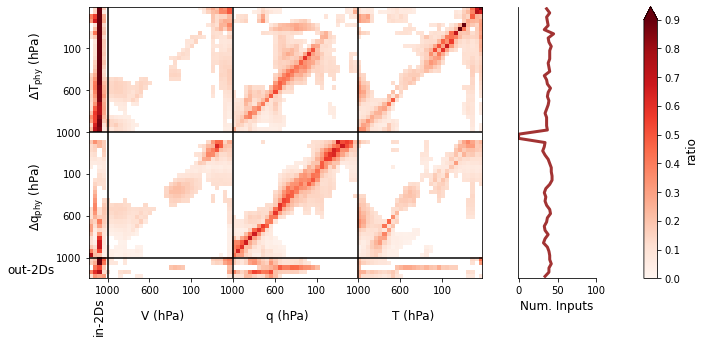

In [9]:
aggregation.plot_matrix_results(
    var_names_parents, 
    aggregated_results, 
    setup, 
    values='percentage',
    insets=insets,
    threshold_dict=threshold_dict,
    num_parents=num_parents,
    save=save,
    masking=masking,
    cmap='Reds',
)

In [10]:
save_numparents_dict = False
# save_numparents_dict = f"./nn_config/quantile_dicts/001_quantile-{setup.thresholds[0]}_numparents.yml"

numparents, numparents_dict = calc_mean_num_parents(aggregated_results, save_numparents_dict=save_numparents_dict)

Mean Num. of Parents is: 36.353846153846156 (38.67430441898527 %)

